In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import pprint
import torch

In [2]:
# Arguments
args = Namespace(
    seed=1024,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=500,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)
pprint.pprint(vars(args),indent = 4)

{   'dimensions': 2,
    'learning_rate': 1.0,
    'num_classes': 3,
    'num_epochs': 200,
    'num_hidden_units': 500,
    'num_samples_per_class': 500,
    'regularization': 0.001,
    'seed': 1024,
    'test_size': 0.25,
    'train_size': 0.75}


In [3]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.25 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    print(np.shape(X_original))
    X = np.hstack([X_original])
    return X, y

In [4]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

(1500, 2)
X: (1500, 2)
y: (1500,)


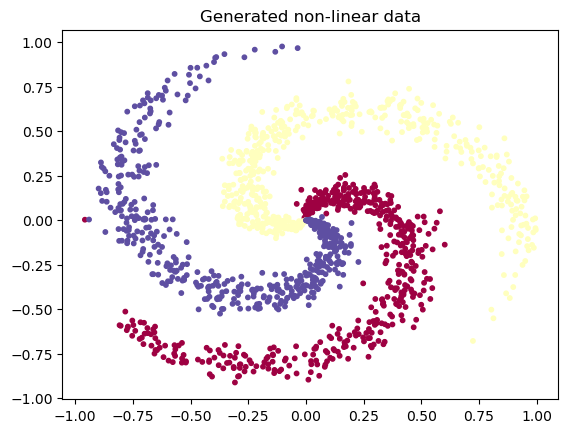

In [5]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(type(X),type(y))
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
print(X.type(),y.type())
print(X)
print(y)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.FloatTensor torch.LongTensor
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 1.4252e-04,  1.9989e-03],
        [ 1.4851e-03,  3.7227e-03],
        ...,
        [-3.8856e-01,  9.1707e-01],
        [-3.5308e-01,  9.3345e-01],
        [-5.6905e-01,  8.2230e-01]])
tensor([0, 0, 0,  ..., 2, 2, 2])


In [7]:
z = random.sample(range(0,len(X)),len(X))
s_index = torch.LongTensor(z)
print(z)
X = X[s_index]
y = y[s_index]
test_index_s = int(len(X) * args.train_size)
print(test_index_s)
X_train = X[:test_index_s]
y_train = y[:test_index_s]
X_test = X[test_index_s:]
y_test = y[test_index_s:]
print("This case contians %i train samples and %i test samples" % (len(X_train), len(y_test)))

[427, 148, 708, 325, 677, 597, 1418, 611, 205, 200, 1075, 664, 1003, 1327, 128, 413, 897, 1203, 1161, 1109, 772, 172, 1341, 1223, 1054, 1136, 348, 1486, 331, 646, 1179, 141, 609, 1335, 444, 883, 923, 1052, 1410, 369, 1429, 143, 1481, 322, 166, 814, 1253, 53, 161, 776, 1268, 586, 1252, 1113, 525, 928, 864, 643, 225, 540, 402, 1314, 1236, 25, 749, 800, 1206, 1172, 235, 329, 350, 226, 299, 1023, 962, 1012, 140, 85, 1363, 1276, 477, 1315, 1218, 95, 1275, 1184, 494, 764, 1182, 1372, 1433, 455, 992, 1385, 120, 1240, 895, 975, 676, 1417, 977, 1133, 751, 660, 658, 824, 304, 722, 398, 61, 1345, 1406, 1157, 777, 961, 545, 428, 917, 1002, 1067, 183, 879, 558, 925, 830, 559, 1375, 1389, 3, 1011, 973, 69, 1095, 1170, 1151, 551, 106, 520, 1068, 1370, 548, 47, 1387, 820, 315, 747, 44, 272, 26, 684, 1408, 561, 819, 1365, 228, 1340, 794, 370, 556, 1279, 375, 397, 949, 77, 196, 1087, 741, 268, 1460, 910, 74, 761, 1150, 530, 1482, 152, 1291, 506, 471, 155, 641, 250, 612, 466, 991, 697, 311, 1461, 1259, 1

In [8]:
# test for a liner model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [9]:
class LogisticClassifier(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(LogisticClassifier,self).__init__()#get init func from nn.Module
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)

    def forward(self,x_in,apply_Softmax = False):
        a_1 = self.fc1(x_in)
        a_2 = self.fc2(a_1)
        y_pred = self.fc3(a_2)

        if apply_Softmax :
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [10]:
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
)>


In [11]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)

In [12]:
def get_Accuracy(y_pred,y_target):
    n_correct = torch.eq(y_pred,y_target).sum().item()
    # how mant numbers about y_pred[element] == y_target[element]
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [13]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim = 1)#index of the max value of y_pred
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)
    loss = loss_f(y_pred,y_train)

    if t%10 == 0:
        print( " epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy
        )
             )
        print(" ----- ----- ----- ----- ----- ----- ----- ----- ")
        print("y_pred:", y_pred)
        print("predicitions:",predictions)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 epoch: 00 | loss: 1.0823 | accuracy: 41.6%
 ----- ----- ----- ----- ----- ----- ----- ----- 
y_pred: tensor([[ 0.3671,  0.1059, -0.0845],
        [ 0.0634, -0.0222, -0.0859],
        [ 0.0286, -0.0840,  0.0039],
        ...,
        [ 0.1495, -0.0157, -0.0286],
        [ 0.1020, -0.0250, -0.0493],
        [ 0.0798, -0.0254, -0.0666]], grad_fn=<AddmmBackward0>)
predicitions: tensor([0, 0, 0,  ..., 0, 0, 0])
 epoch: 10 | loss: 45383.8320 | accuracy: 53.7%
 ----- ----- ----- ----- ----- ----- ----- ----- 
y_pred: tensor([[ 303944.0938, -506993.9375,  139066.1875],
        [ -30900.9336,  102556.8047,    3493.3594],
        [ -94106.3594,   65175.5703,   79249.2656],
        ...,
        [  48295.3906, -138159.4062,   99746.1172],
        [   1561.3208,  -18228.5684,   57650.8672],
        [ -18127.5117,   46605.7109,   30403.9551]], grad_fn=<AddmmBackward0>)
predicitions: tensor([0, 1, 2,  ..., 2, 2, 1])
 epoch: 20 | loss: 38737.1641 | accuracy: 57.7%
 ----- ----- ----- ----- ----- -----

In [14]:
_,pred_train = model(X_train,apply_Softmax = True).max(dim = 1)
_,pred_test = model(X_test,apply_Softmax = True).max(dim = 1)
print("pred_train:",pred_train)
print("----- ----- ----- ----- -----")
print("pred_test:",pred_test)


pred_train: tensor([0, 1, 2,  ..., 2, 1, 1])
----- ----- ----- ----- -----
pred_test: tensor([0, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1,
        0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 2, 1, 2,
        1, 1, 1, 2, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1,
        2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0,
        2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2,
        1, 2, 1, 0, 2, 2, 1, 1, 1,

In [15]:
# Train and test accuracies
train_acc = get_Accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_Accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 41.4%, test acc: 43.7%


In [16]:
def plot_multiclass_decision_boundary(model,X,y):
    x_min = X[:,0].min()-0.1
    x_max = X[:,0].max() + 0.1
    y_min = X[:,1].min() - 0.1
    y_max = X[:,1].max() + 0.1
    xx,yy = np.meshgrid( np.linspace( x_min,x_max,101 ),np.linspace( y_min,y_max,101 ) )

    X_test = torch.from_numpy(np.c_[xx.ravel(),yy.ravel()]).float()
    y_pred = model(X_test,apply_Softmax = True)
    _,y_pred = y_pred.max(dim = 1)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    

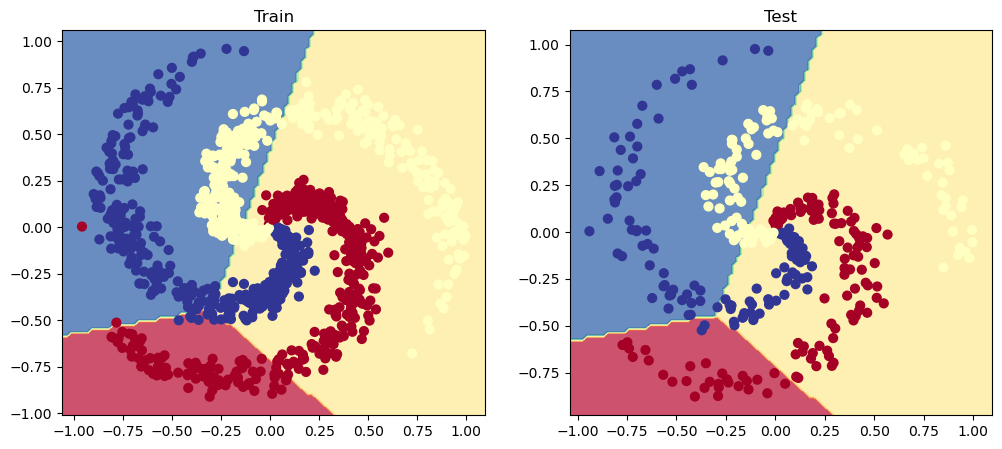

In [17]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()
